# Image registration of an EBSD data set to a BSE image

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

In [45]:
# Switch to interactive Matplotlib backend (e.g. qt5) for control point determination
#%matplotlib qt5
%matplotlib inline

from datetime import date
import importlib_metadata
import os

from dask.diagnostics import ProgressBar
import dask
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import morphops
import numpy as np
from orix import io as oio
from orix.crystal_map import CrystalMap
from orix.quaternion import Rotation
import skimage.color as skc
import skimage.exposure as ske
import skimage.transform as skt
import skimage.util as sku
from tqdm import trange


# Directories
dset_no = 3
dir_data = "/home/hakon/phd/data/p/prover/300c"
dir_sample = os.path.join(dir_data, str(dset_no))
dir_bse = os.path.join(dir_sample, "bse")
dir_kp = os.path.join(dir_sample, "kp")
dir_suppl = "/home/hakon/phd/artikler_abstract/202104_correlating_ebsd_bse/latex/supplementary/fig"

# Data set specific parameters
n_cps = {1: 82, 2: 95, 3: 89}
out_shapes = {1: (1000, 1000), 2: (900, 820), 3: (1050, 950)}

# Matplotlib
plt.rcParams.update({"font.size": 12, "figure.dpi": 150})
savefig_kw = dict(bbox_inches="tight", pad_inches=0, transparent=True)

print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in [
    "dask",
    "matplotlib",
    "morphops",
    "numpy",
    "orix",
    "scikit-image",
    "tqdm"
]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-04-19

Software versions
-----------------
dask : 2022.3.0
matplotlib : 3.4.3
morphops : 0.1.13
numpy : 1.21.5
orix : 0.9.dev0
scikit-image : 0.19.2
tqdm : 4.63.1


Step sizes

In [46]:
delta = dict(ebsd=100, bse=1 / 38.5e-3)

New BSE scale so that the particle map produced from the upscaled BSE image can be binned by an integer factor

In [47]:
x_bin = int(np.ceil(delta["ebsd"] / delta["bse"]))
upscale_factor = x_bin * (delta["bse"] / delta["ebsd"])

## 1. Manually identify control points

EBSD map (sensed image)

In [48]:
ebsd = plt.imread(os.path.join(dir_kp, "maps_mean_q1_q99.png"))
ebsd = skc.rgb2gray(ebsd[..., :3])

BSE image (reference image)

In [49]:
bse = plt.imread(os.path.join(dir_bse, "4500x_cropped2_fused_crop.png"))
bse = skc.rgb2gray(bse[..., :3])

Identify coordinates (x, y) and (X, Y) of corresponding control points and write
them to a text file

In [69]:
#fig, (ax0, ax1) = plt.subplots(ncols=2)
#ax0.imshow(ebsd, cmap="gray")
#ax1.imshow(bse, cmap="gray");

Load identified control points

In [50]:
cpx_ebsd, cpy_ebsd, cpx_bse, cpy_bse = np.loadtxt(
    os.path.join(dir_bse, "cps_300c_cropped2_fused_crop.csv"),
    skiprows=1,
    max_rows=n_cps[dset_no],
    usecols=(1, 2, 3, 4),
    delimiter=",",
    unpack=True,
)
cp_ebsd = np.column_stack([cpy_ebsd, cpx_ebsd])
cp_bse = np.column_stack([cpy_bse, cpx_bse])

## 2. Scale out control point coordinates in

In [51]:
cp_bse_scaled = cp_bse / (delta["ebsd"] / delta["bse"])

## 3. Correct source image using the thin plate spline transformation function

Get inverse map (input coordinates in the output image) using `morphops`. We use `dask` to wrap calls to `morphops` to keep memory use low.

In [52]:
out_shape = out_shapes[dset_no]
out_size = int(np.prod(out_shape))
rc_out = np.indices(out_shape, dtype=float).reshape((2, -1)).T

delayed_list = []
n_chunks = 100
chunk_size = int(np.ceil(out_size / n_chunks))
for idx in range(0, n_chunks * chunk_size, chunk_size):
    rc_chunk = rc_out[idx:idx + chunk_size]
    rc_in_part = dask.delayed(morphops.tps_warp)(X=cp_bse_scaled, Y=cp_ebsd, pts=rc_chunk)
    delayed_list.append(rc_in_part)

with ProgressBar():
    rc_in_parts = dask.compute(*delayed_list)
rc_in = np.row_stack(rc_in_parts)

[########################################] | 100% Completed |  3.4s


Check coordinate shifts

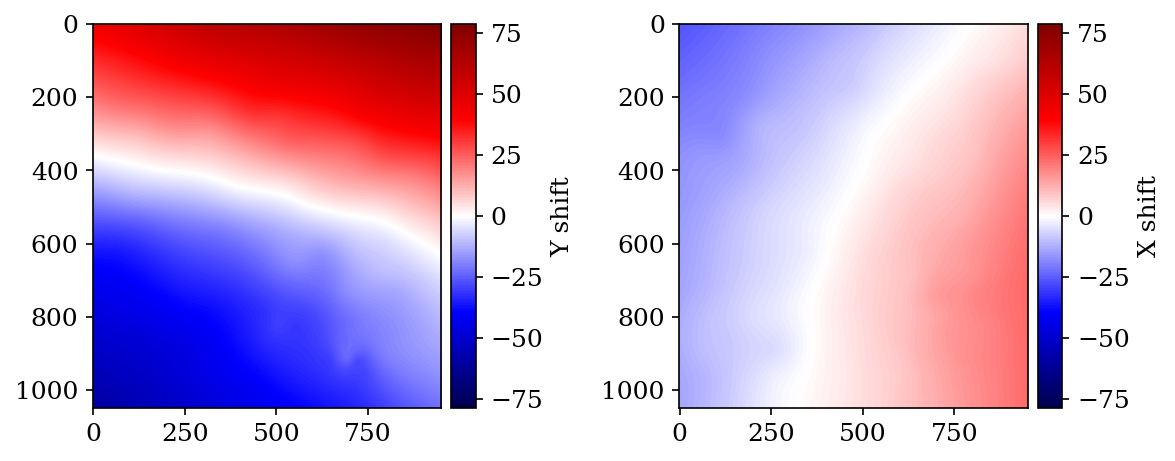

In [53]:
rc_shift = rc_in - rc_out
rc_center = rc_shift - rc_shift.mean(axis=0)

labels = ("Y shift", "X shift")
v_extent = max(abs(rc_center.min()), abs(rc_center.max()))
imshow_kwds = dict(vmin=-v_extent, vmax=v_extent, cmap="seismic")

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for i, a in enumerate(ax):
    im = a.imshow(rc_center[:, i].reshape(out_shape), **imshow_kwds)
    ax_divider = make_axes_locatable(a)
    fig.colorbar(im, cax=ax_divider.append_axes("right", size="7%", pad="3%"), label=labels[i])
fig.tight_layout()

In [54]:
def get_mapping_arrays(rc_in, in_shape, out_shape):
    """Get 1D indices of corresponding points in input and output
    arrays.
    
    Parameters
    ----------
    rc_in : numpy.ndarray
    in_shape : tuple
    out_shape : tuple
    
    Returns
    -------
    rc_in_1d : numpy.ndarray
    rc_in_2d : tuple of numpy.ndarray
    rc_out_1d : numpy.ndarray
    rc_out_2d : tuple of numpy.ndarray
    """
    # Round exact input coordinates to nearest neighbour coordinates
    rc_in_int = np.round(rc_in).astype(int)

    # Set up output coordinate array
    rc_out = np.indices(out_shape).reshape((2, -1)).T
    
    # Remove coordinates outside input map in both arrays
    is_outside = np.logical_or((rc_in_int < 0).any(axis=1), (rc_in_int >= np.array(in_shape)).any(axis=1))
    is_outside_idx = np.where(is_outside)[0]
    rc_in_int = np.delete(rc_in_int, is_outside_idx, axis=0)
    rc_out = np.delete(rc_out, is_outside_idx, axis=0)
    
    # Get 1D indices
    rc_in_1d = np.ravel_multi_index(rc_in_int.T, in_shape)
    rc_out_1d = np.ravel_multi_index(rc_out.T, out_shape)

    # 2D coordinate arrays
    rc_in_2d = np.unravel_index(rc_in_1d, in_shape)
    rc_out_2d = np.unravel_index(rc_out_1d, out_shape)
    
    return rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d


def map_in_image(in_image, out_shape, rc_in_2d, rc_out_2d):
    """Map sensed (in) image from sensed coordinates to
    reference coordinates.
    
    Parameters
    ----------
    in_image : numpy.ndarray
    out_shape : tuple
    rc_in_2d : tuple of numpy.ndarray
    rc_out_2d : tuple of numpy.ndarray
    
    Returns
    -------
    out_image : numpy.ndarray
    """
    out_image = np.zeros(out_shape, dtype=in_image.dtype)
    out_image[rc_out_2d] = in_image[rc_in_2d]
    return out_image

In [55]:
rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d = get_mapping_arrays(
    rc_in=rc_in, in_shape=ebsd.shape, out_shape=out_shape
)

Check mapping of EBSD intensity map

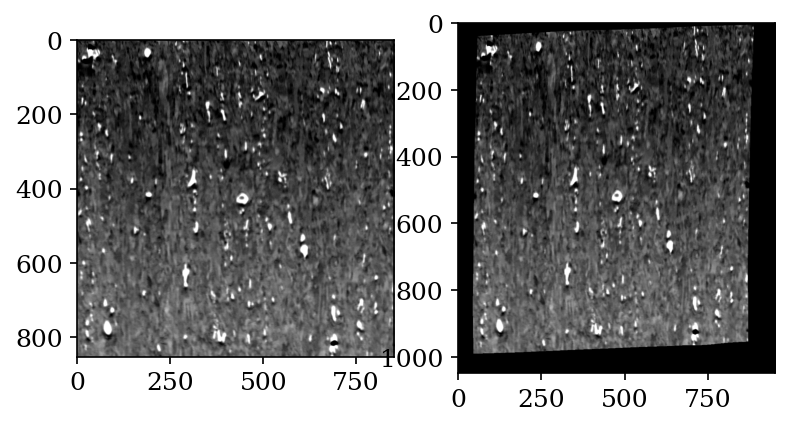

In [56]:
ebsd_correct = map_in_image(ebsd, out_shape, rc_in_2d, rc_out_2d)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(ebsd, cmap="gray")
ax[1].imshow(ebsd_correct, cmap="gray");

In [17]:
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True

plt.imsave(os.path.join(dir_bse, "ebsd_correct.png"), ebsd_correct, cmap="gray")
np.save(os.path.join(dir_bse, "mask_ebsd_correct"), mask)

Check overlap of EBSD map and BSE image

In [18]:
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True

scale = delta["ebsd"] / delta["bse"]
mask2 = skt.rescale(mask, scale).astype(bool)
ebsd_correct2 = skt.rescale(ebsd_correct, scale)
mask2 = mask2[:bse.shape[0], :bse.shape[1]]
ebsd_correct3 = ebsd_correct2[:bse.shape[0], :bse.shape[1]]

bse2 = bse.copy()
bse2[~mask2] = 0

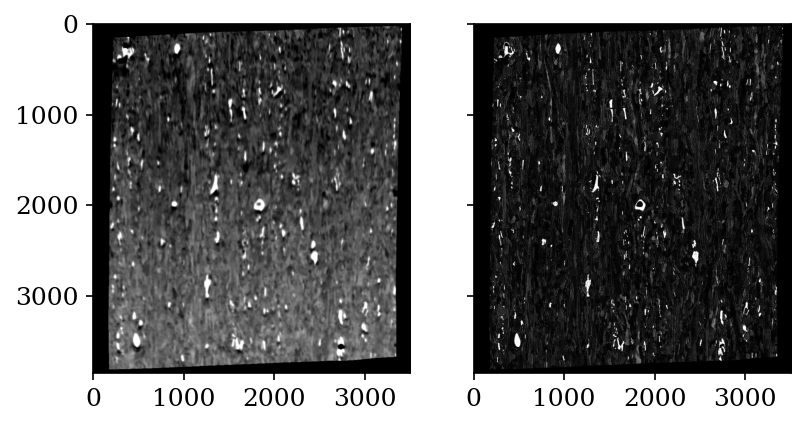

In [19]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].imshow(ebsd_correct3, cmap="gray")
ax[1].imshow(bse2, cmap="gray");

Check similarity of corrected EBSD map and BSE image

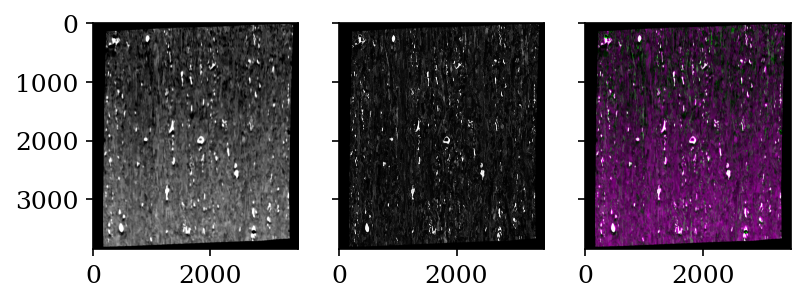

In [20]:
ebsd_correct4 = ske.rescale_intensity(ebsd_correct3, out_range=(0, 1))
bse3 = ske.rescale_intensity(bse2, out_range=(0, 1))
reg_im = np.stack((ebsd_correct4, bse3, ebsd_correct4), axis=2)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharex=True, sharey=True)
ax0.imshow(ebsd_correct4, cmap="gray")
ax1.imshow(bse3, cmap="gray")
ax2.imshow(reg_im);

In [21]:
# With padding
plt.imsave(os.path.join(dir_bse, "reg_ebsd.png"), ebsd_correct4, cmap="gray")
plt.imsave(os.path.join(dir_bse, "reg_bse.png"), bse3, cmap="gray")
plt.imsave(os.path.join(dir_bse, "reg_rgb.png"), reg_im)

In [22]:
# Save images also without padding
rc_out_2d_scale = np.column_stack(rc_out_2d) * scale
r_start, c_start = np.floor(rc_out_2d_scale.min(axis=0)).astype(int)
r_end, c_end = np.ceil(rc_out_2d_scale.max(axis=0)).astype(int)
sl = (slice(r_start, r_end), slice(c_start, c_end))
plt.imsave(os.path.join(dir_bse, "reg_ebsd_no_padding.png"), ebsd_correct4[sl], cmap="gray")
plt.imsave(os.path.join(dir_bse, "reg_bse_no_padding.png"), bse3[sl], cmap="gray")
plt.imsave(os.path.join(dir_bse, "reg_rgb_no_padding.png"), reg_im[sl])

## 4. Upsample source image before particle detection

In [23]:
bse4 = skt.rescale(bse, upscale_factor)
plt.imsave(os.path.join(dir_bse, "bse_rescaled.png"), bse4, cmap="gray")

## 5. Detect particles in upscaled source image

Done in notebook `particle_detection.ipynb`.

## 6. Bin particle map and extract only ROI

In [57]:
labels = np.load(os.path.join(dir_bse, "bse_labels_filled_filtered.npy"))

In [58]:
row_labels, col_labels = labels.shape
row_new = row_labels - (row_labels % x_bin)
col_new = col_labels - (col_labels % x_bin)
labels2 = labels[:row_new, :col_new]
view = sku.view_as_blocks(labels2, block_shape=(x_bin, x_bin))

In [59]:
def count_particles(block):
    unique_labels = np.unique(block)
    particle_labels = unique_labels > 0
    return np.count_nonzero(particle_labels)


n_particles = np.zeros(view.shape[:2])
for idx in np.ndindex(view.shape[:-2]):
    n_particles[idx] = count_particles(view[idx])

Make particle map of equal size to new EBSD data

In [60]:
n_particles_roi = np.zeros(out_shape, dtype=int)
nr_part, nc_part = n_particles.shape
n_particles_roi[:nr_part, :nc_part] = n_particles

# Mask to ROI only
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True
n_particles_roi[~mask] = 0

Check overlap

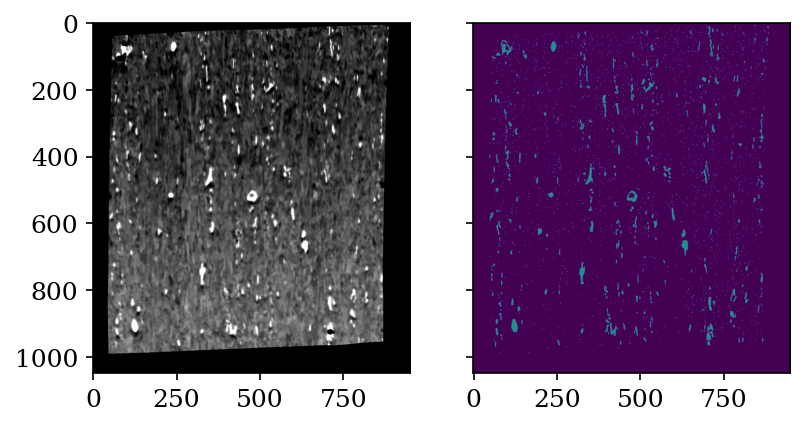

In [61]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].imshow(ebsd_correct, cmap="gray")
ax[1].imshow(n_particles_roi);

Save to file

In [30]:
np.save(os.path.join(dir_bse, "n_particles"), n_particles)
np.save(os.path.join(dir_bse, "n_particles_roi"), n_particles_roi)

## 7. Create new crystal map with corrected coordinates and particle locations

In [31]:
xmap_refori = oio.load(os.path.join(dir_kp, "xmap_refori.h5"))
xmap_refori.scan_unit = "um"

Get BSE ROI to insert into crystal map

In [32]:
# Rescale
bse5 = skt.rescale(bse, delta["bse"] / delta["ebsd"])

# Pad
pad_bse = np.array(out_shape) - np.array(bse5.shape)
bse_roi = np.pad(bse5, ((0, pad_bse[0]), (0, pad_bse[1])))

# Mask
bse_roi[~mask] = 0

Map EBSD orientations, phase IDs etc.

In [33]:
# Rotations
rot_out = Rotation.identity((out_size,))
rot_out[rc_out_1d] = xmap_refori._rotations[rc_in_1d]

# Phase ID
phase_id_out = -np.ones(out_size, dtype=int)
phase_id_out[rc_out_1d] = xmap_refori._phase_id[rc_in_1d]

# Spatial coordinates
y_out, x_out = rc_out.T * xmap_refori.dx

# Current properties
prop_out = {}
for k, v in xmap_refori.prop.items():
    prop = np.full(out_size, fill_value=0, dtype=v.dtype)
    prop[rc_out_1d] = v[rc_in_1d]
    prop_out[k] = prop

# New properties
r_shift, c_shift = rc_shift.T
prop_out["r_shift"] = r_shift
prop_out["c_shift"] = c_shift
prop_out["n_particles"] = n_particles_roi.flatten()
prop_out["bse"] = bse_roi.flatten()

# Is in data mask
is_in_data_out = np.zeros(out_size, dtype=bool)
is_in_data_out[rc_out_1d] = True

# Get new crystal map
xmap_refori2 = CrystalMap(
    rotations=rot_out,
    phase_id=phase_id_out,
    phase_list=xmap_refori.phases,
    x=x_out,
    y=y_out,
    prop=prop_out,
    scan_unit=xmap_refori.scan_unit,
    is_in_data=is_in_data_out,
)

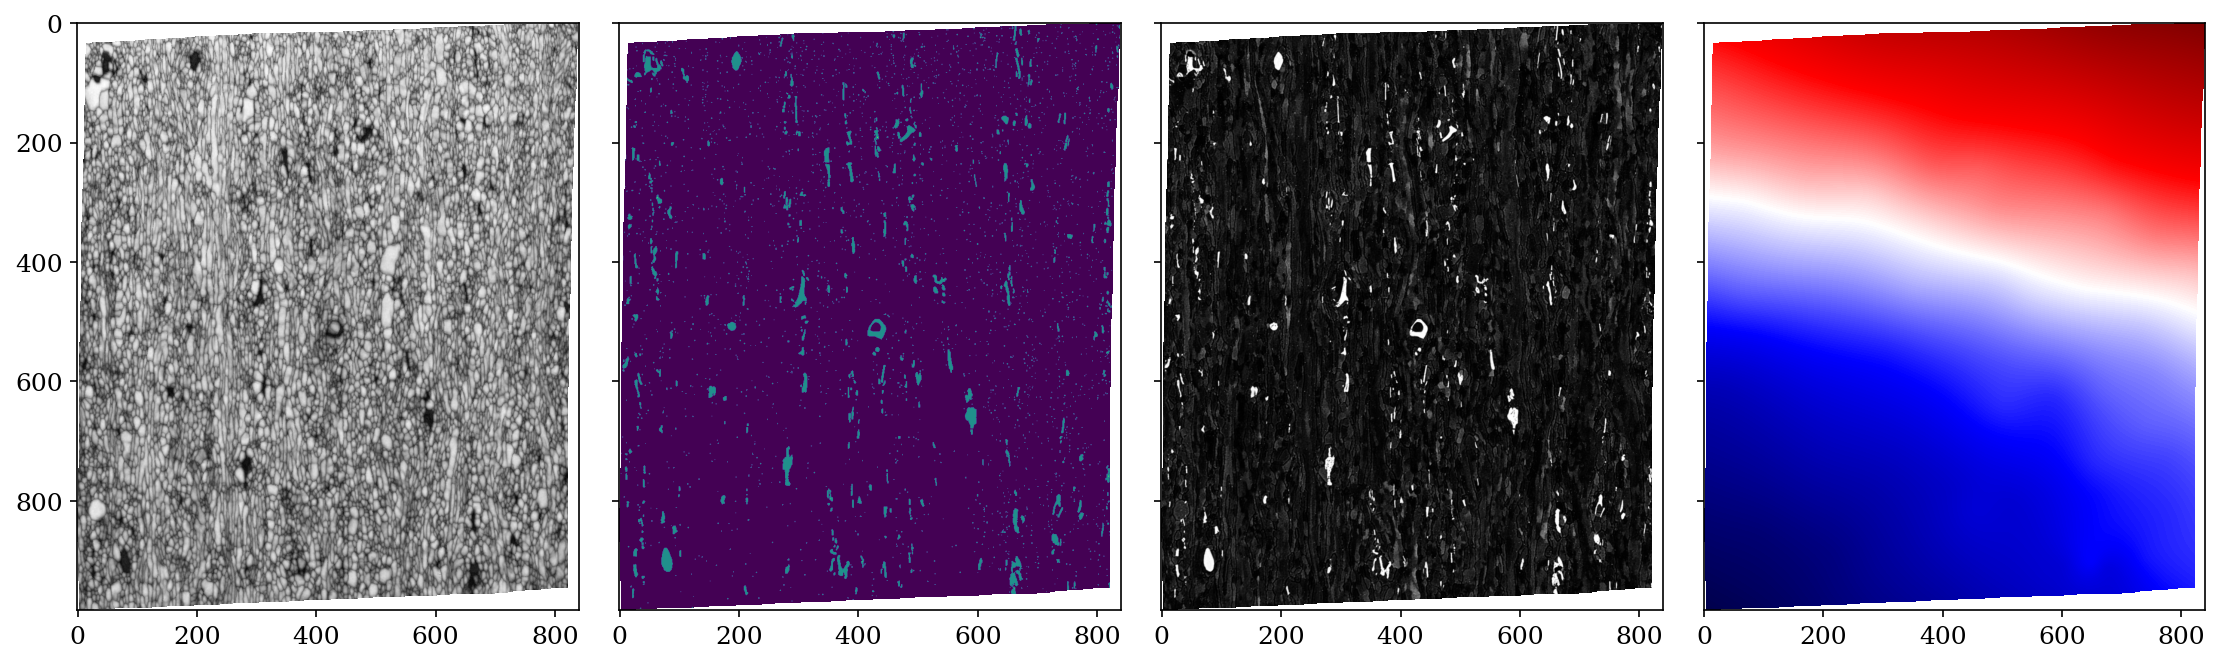

In [34]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(15, 5))
ax[0].imshow(xmap_refori2.get_map_data("scores"), cmap="gray")
ax[1].imshow(xmap_refori2.get_map_data("n_particles"))
ax[2].imshow(xmap_refori2.get_map_data("bse"), cmap="gray")
ax[3].imshow(xmap_refori2.get_map_data("r_shift"), cmap="seismic")
fig.tight_layout();

In [35]:
oio.save(os.path.join(dir_kp, "xmap_refori2.h5"), xmap_refori2, overwrite=True)
oio.save(
    os.path.join(dir_kp, "xmap_refori2.ang"),
    xmap_refori2,
    extra_prop=["n_particles", "r_shift", "c_shift", "bse"],
    overwrite=True
)

Compare map areas before and after correction

In [36]:
# Shape of ROI
nominal_shape = np.array(xmap_refori.shape) * xmap_refori.dx
actual_shape = (
    xmap_refori2.y.max() - xmap_refori2.y.min(),
    xmap_refori2.x.max() - xmap_refori2.x.min()
)
print(
    "ROI\n---",
    "\nNominal (square):\t", np.round(nominal_shape, decimals=1), "um^2",
    "\nActual (non-square):\t", np.round(actual_shape, decimals=1), "um^2"
)

# Total area of scanned points
nominal_area = xmap_refori.size * xmap_refori.dx ** 2
actual_area = xmap_refori2.size * xmap_refori2.dx ** 2
print(
    "\nArea\n----",
    f"\nNominal:\t\t {nominal_area:.2f} um^2",
    f"\nActual:\t\t\t {actual_area:.2f} um^2",
    f"\nActual / nominal:\t {100 * actual_area / nominal_area:.1f}%",
)

ROI
--- 
Nominal (square):	 [85.3 85.3] um^2 
Actual (non-square):	 [98.3 83.9] um^2

Area
---- 
Nominal:		 7276.09 um^2 
Actual:			 7834.97 um^2 
Actual / nominal:	 107.7%


## Compare similarity of corrected EBSD map and BSE image

In [33]:
def norm_data(a):
    return (a - np.mean(a)) / np.std(a)


def ncc(a, b):
    return np.sum(norm_data(a) * norm_data(b)) / a.size


def draw_random_control_points(cp_bse, cp_ebsd, n):
    n_all = cp_bse.shape[0]
    keep_idx = np.random.choice(np.arange(n_all), size=n_all - n, replace=False)
    return cp_bse_scaled[keep_idx], cp_ebsd[keep_idx], keep_idx

Similarity with all CPs

In [34]:
ncc(ebsd_correct3[mask2], bse2[mask2])

0.2243524983418782

In [35]:
scale = delta["ebsd"] / delta["bse"]

out_shape = out_shapes[dset_no]
out_size = int(np.prod(out_shape))
rc_out = np.indices(out_shape, dtype=float).reshape((2, -1)).T
n_chunks = 100
chunk_size = int(np.ceil(out_size / n_chunks))

Remove CPs in steps and perform 30 trials per n removals (takes about 10 minutes with the given parameters)

In [36]:
subtract = np.arange(5, n_cps[dset_no] - 5, 5)
n_trials = 30

ncc_scores = np.zeros((len(subtract), n_trials))
n_cps_all = cp_ebsd.shape[0]
cps_keep_idx = np.zeros((len(subtract), n_trials, n_cps_all), dtype=int)

for i, sub in enumerate(subtract):
    delayed_list = []
    for trial in range(n_trials):
        cp_bse_scaled2, cp_ebsd2, keep_idx = draw_random_control_points(cp_bse_scaled, cp_ebsd, sub)
        cps_keep_idx[i, trial, :n_cps_all - sub] = keep_idx
        for idx in range(0, n_chunks * chunk_size, chunk_size):
            rc_chunk = rc_out[idx:idx + chunk_size]
            rc_in_part = dask.delayed(morphops.tps_warp)(X=cp_bse_scaled2, Y=cp_ebsd2, pts=rc_chunk)
            delayed_list.append(rc_in_part)

    with ProgressBar():
        rc_in_all = np.stack(dask.compute(*delayed_list)).reshape((n_trials, out_size, 2))

    for trial in trange(n_trials):
        rc_in = rc_in_all[trial]
        rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d = get_mapping_arrays(
            rc_in=rc_in, in_shape=ebsd.shape, out_shape=out_shape
        )
        
        ebsd_correct_i = map_in_image(ebsd, out_shape, rc_in_2d, rc_out_2d)
        ebsd_correct2_i = skt.rescale(ebsd_correct_i, scale)
        ebsd_correct3_i = ebsd_correct2_i[:bse.shape[0], :bse.shape[1]]
        
        mask_i = np.zeros(out_shape, dtype=bool)
        mask_i[rc_out_2d] = True
        mask2_i = skt.rescale(mask_i, scale).astype(bool)
        mask2_i = mask2_i[:bse.shape[0], :bse.shape[1]]

        ncc_scores[i, trial] = ncc(ebsd_correct3_i[mask2_i], bse[mask2_i])
    print(f"{sub}: ", ncc_scores[i].mean())

[########################################] | 100% Completed |  1min  9.8s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]


5:  0.2227203728362776
[########################################] | 100% Completed |  1min  7.2s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.88it/s]


10:  0.22262028936606928
[########################################] | 100% Completed |  1min  5.8s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.90it/s]


15:  0.22124223855913153
[########################################] | 100% Completed |  1min  4.8s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.99it/s]


20:  0.22089006353478297
[########################################] | 100% Completed |  1min  4.2s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.90it/s]


25:  0.22006783963388965
[########################################] | 100% Completed | 59.2s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]


30:  0.21871599959682048
[########################################] | 100% Completed |  1min  7.2s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.78it/s]


35:  0.21831589841657778
[########################################] | 100% Completed | 52.7s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.99it/s]


40:  0.21630587962678885
[########################################] | 100% Completed | 53.1s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]


45:  0.2153600543511603
[########################################] | 100% Completed | 48.2s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]


50:  0.21295130363397569
[########################################] | 100% Completed | 41.3s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.88it/s]


55:  0.21197015544590103
[########################################] | 100% Completed | 32.0s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]


60:  0.21209140375609895
[########################################] | 100% Completed | 38.1s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]


65:  0.20917582108271202
[########################################] | 100% Completed | 28.3s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]


70:  0.2091119553656288
[########################################] | 100% Completed | 23.0s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]


75:  0.20244306831693573
[########################################] | 100% Completed | 22.7s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.89it/s]


80:  0.19033708856837667
[########################################] | 100% Completed |  6.8s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]

85:  0.18034647311151586


Save results to file

In [37]:
np.save(os.path.join(dir_bse, "cps_keep_idx"), cps_keep_idx)
np.save(os.path.join(dir_bse, "ncc_scores"), ncc_scores)

Plot absolute decrease in $r$

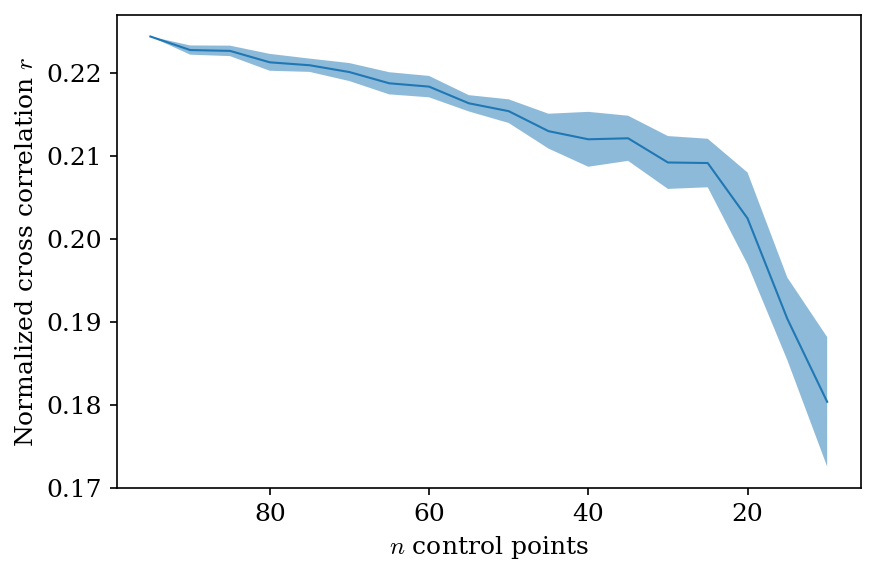

In [38]:
n_cps_used = n_cps_all - np.array(subtract)
ncc_scores_mean = ncc_scores.mean(axis=1)
conf_int = 1.96 * ncc_scores.std(axis=1) / np.sqrt(n_trials)

# Prepend all CPs
n_cps_used = np.append(n_cps_used[::-1], n_cps_all)[::-1]
ncc_scores_mean = np.append(ncc_scores_mean[::-1], ncc(ebsd_correct3[mask2], bse2[mask2]))[::-1]
conf_int = np.append(conf_int[::-1], 0)[::-1]

fig, ax = plt.subplots()
ax.plot(n_cps_used, ncc_scores_mean)
ax.fill_between(n_cps_used, y1=ncc_scores_mean - conf_int, y2=ncc_scores_mean + conf_int, alpha=0.5)
ax.invert_xaxis()
ax.set_xlabel("Control points used in registration")
ax.set_ylabel(r"Normalized cross correlation $\rho$")
fig.tight_layout()
fig.savefig(os.path.join(dir_bse, "ncc_vs_n_cps.png"), **savefig_kw)

Plot relative increase in the difference of $r$

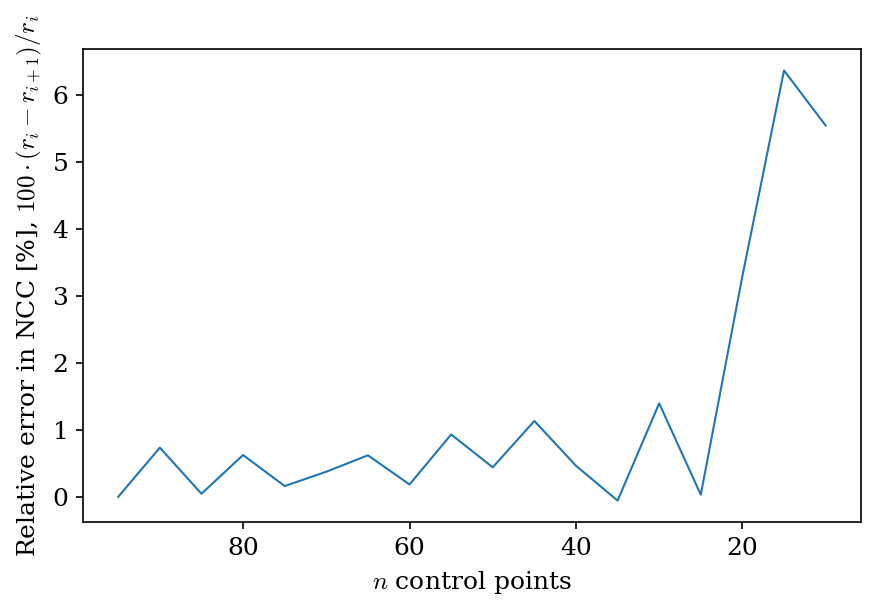

In [39]:
ncc_diff = np.append(np.diff(ncc_scores_mean[::-1]), 0)[::-1]
ncc_diff_rel = 100 * ncc_diff / ncc_scores_mean

fig, ax = plt.subplots()
ax.plot(n_cps_used, ncc_diff_rel)
ax.invert_xaxis()
ax.set_xlabel("Control points used in registration")
ax.set_ylabel(r"Relative error in $\rho$ [%], $100 \cdot (\rho_i - \rho_{i + 1}) / \rho_i$")
fig.tight_layout()
fig.savefig(os.path.join(dir_bse, "ncc_error_vs_n_cps.png"), **savefig_kw)

### Similarity of corrected EBSD map and BSE image from all three data sets

In [4]:
ncc_scores_all = []
n_cps_kept = []
for i in range(1, 4):
    dir_bse_i = os.path.join(dir_data, str(i), "bse")
    ncc_scores_i = np.load(os.path.join(dir_bse_i, "ncc_scores.npy"))
    ncc_scores_all.append(ncc_scores_i)
    
    n_cps_kept.append(np.arange(5, n_cps[i] - 5, 5))

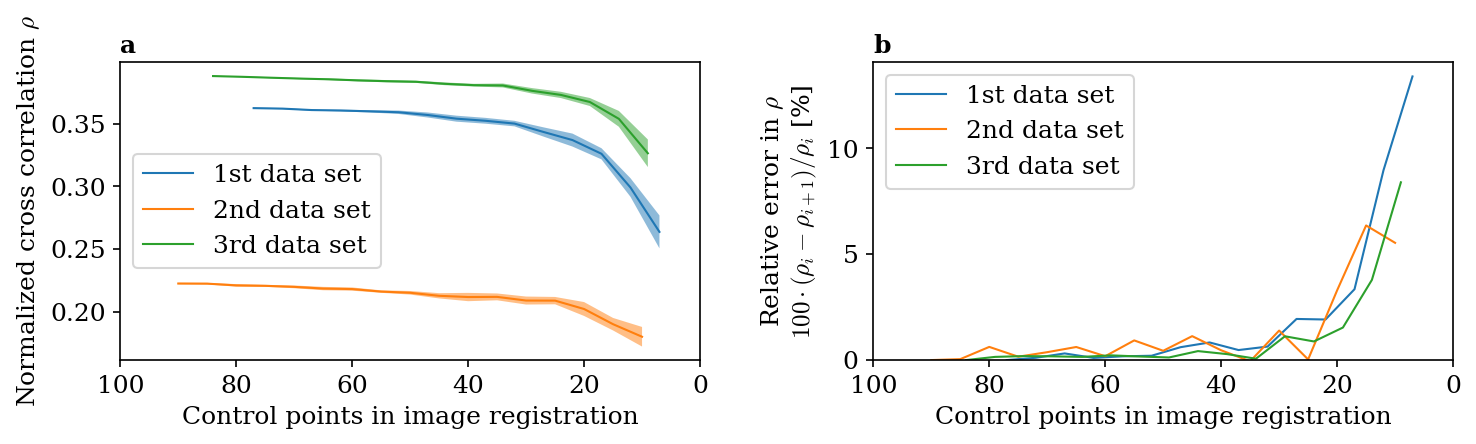

In [13]:
n_trials = ncc_scores_all[0].shape[1]

labels = ["1st", "2nd", "3rd"]

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
for i in range(3):
    label_i = f"{labels[i]} data set"
    n_cps_used_i = n_cps[i + 1] - n_cps_kept[i]
    ncc_scores_mean_i = ncc_scores_all[i].mean(axis=1)
    conf_int_i = 1.96 * ncc_scores_all[i].std(axis=1) / np.sqrt(n_trials)
    ax[0].plot(n_cps_used_i, ncc_scores_mean_i, label=label_i)
    ax[0].fill_between(
        n_cps_used_i, y1=ncc_scores_mean_i - conf_int_i,
        y2=ncc_scores_mean_i + conf_int_i,
        alpha=0.5
    )

    ncc_diff_i = np.append(np.diff(ncc_scores_mean_i[::-1]), 0)[::-1]
    ncc_diff_rel_i = 100 * ncc_diff_i / ncc_scores_mean_i
    ax[1].plot(n_cps_used_i, ncc_diff_rel_i, label=label_i)

ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[0].set_xlim(100, 0)
ax[1].set_xlim(100, 0)
ax[1].set_ylim(0)
ax[0].set_xlabel("Control points in image registration")
ax[1].set_xlabel("Control points in image registration")
ax[0].set_ylabel(r"Normalized cross correlation $\rho$")
ax[1].set_ylabel(r"Relative error in $\rho$" + "\n" + r"$100 \cdot (\rho_i - \rho_{i + 1}) / \rho_i$ [%]")
ax[0].text(0, 1.03, "a", fontweight="bold", transform=ax[0].transAxes) 
ax[1].text(0, 1.03, "b", fontweight="bold", transform=ax[1].transAxes) 
ax[0].legend()
ax[1].legend()
fig.tight_layout()

fig.savefig(
    os.path.join(dir_suppl, "registration_similarity", "registration_similarity.pdf"),
    **savefig_kw
)